# Climate Analysis
---

## Import Dependencies

In [22]:
# Python SQL toolkit and Object Relational Mapper
from sqlalchemy import create_engine, inspect, func
from sqlalchemy.orm import sessionmaker
from sqlalchemy.ext.automap import automap_base

In [23]:
# Matplotlib Graphing
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')

import matplotlib.pyplot as plt

In [24]:
# Data Manipulation/Analysis
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLAlchemy ORM

In [25]:
# Create engine to hawaii.sqlite
engine = create_engine('sqlite:///Resources/hawaii.sqlite')

### Inspection

In [26]:
# Creating an Inspector to help
inspector = inspect(engine)

In [27]:
def get_schema(table):
    measurement_col = inspector.get_columns(str(table))
    for column in measurement_col:
        print(column['name'], column['type'])

#### Measurement Table - Columns

In [28]:
get_schema('Measurement')

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


#### Station Table - Columns

In [29]:
get_schema('Station')

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


### AutoMapping to Base

In [30]:
# Reflect an existing database into a new model
Base = automap_base()

# Reflect the tables
Base.prepare(autoload_with = engine)

In [31]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [32]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

## Sessionmaker Binding for Sessions

In [33]:
# Create our session config (link) from Python to the DB
Session = sessionmaker(bind = engine)

## Exploratory Precipitation Analysis

### Query - Most Recent Date

In [34]:
# Find the most recent date in the data set.
with Session() as session:
    first_date = session.query(
        func.max(measurement.date)
        ).scalar()

first_date = dt.datetime.strptime(first_date, '%Y-%m-%d')
print(first_date)

2017-08-23 00:00:00


### Query - Precipitation Prior Year

In [35]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
last_date = first_date - dt.timedelta(days = 365)

# Perform a query to retrieve the data and precipitation scores
sel = [
    measurement.date
    ,measurement.prcp
]

with Session() as session:
    data = session.query(*sel
        ).filter(measurement.date >= last_date
        ).all()

### Plot - Precipitation Prior Year

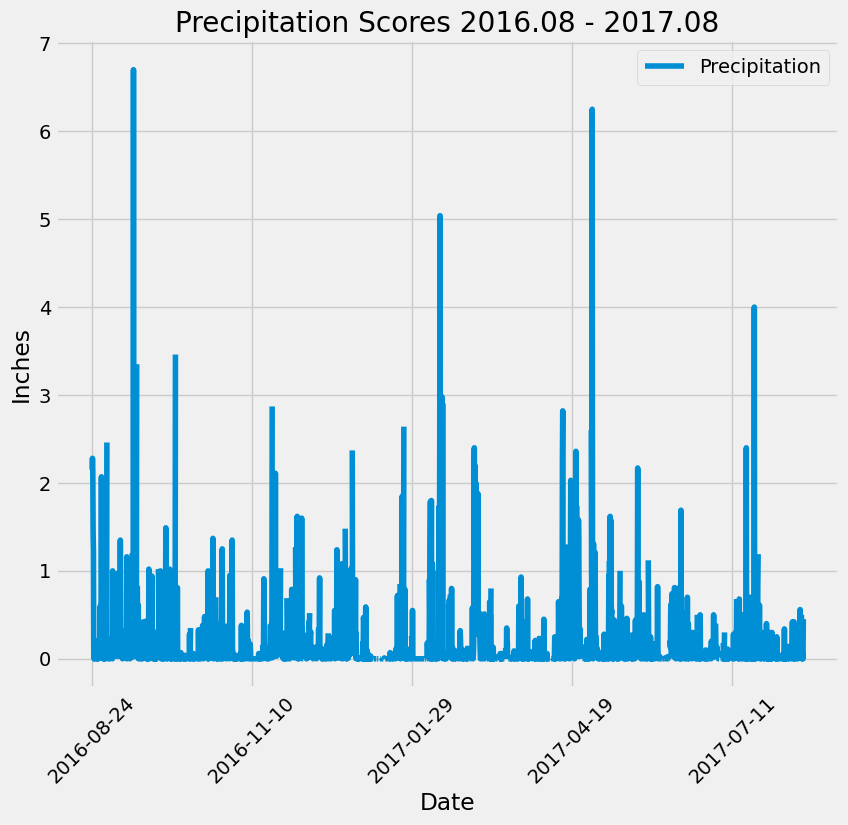

In [36]:
# Save the query results as a Pandas DataFrame. Explicitly set the column names
prcp_df = pd.DataFrame(data
    ).rename(
        columns = {
            'date': 'Date'
            ,'prcp': 'Precipitation'
        }
    ).sort_values('Date')

prcp_df.plot(
    figsize = (9, 8)
    ,x = 'Date'
    ,y = 'Precipitation'
    ,ylabel = 'Inches'
    ,title = f'Precipitation Scores {last_date.strftime('%Y.%m')} - {first_date.strftime('%Y.%m')}'
)
plt.xticks(rotation = 45)
plt.show()

### Summary Statistics

In [37]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_df.set_index('Date', drop = True).describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Exploratory Station Analysis

### Query - Number of Stations

In [38]:
# Design a query to calculate the total number of stations in the dataset
with Session() as session:
    data = session.query(func.count(station.id)).scalar()

print(f'Number of Stations: {data}')

Number of Stations: 9


### Query - Most Active Stations

In [39]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_count = func.count(measurement.station)

sel = [
    measurement.station
    ,station_count
]

with Session() as session:
    data = session.query(*sel
        ).group_by(measurement.station
        ).order_by(station_count.desc()
        ).all()

print('Station     | Count')
for station, count in data:
    print(f'{station} | {count}')

Station     | Count
USC00519281 | 2772
USC00519397 | 2724
USC00513117 | 2709
USC00519523 | 2669
USC00516128 | 2612
USC00514830 | 2202
USC00511918 | 1979
USC00517948 | 1372
USC00518838 | 511


In [40]:
most_active = data[0][0]

print(f'The station with the most number of observations is {most_active}')

The station with the most number of observations is USC00519281


### Query - TOB @ Most Active Station

In [41]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [
    func.min(measurement.tobs)
    ,func.max(measurement.tobs)
    ,func.avg(measurement.tobs)
]

with Session() as session:
    data = session.query(*sel
        ).filter(measurement.station == most_active
        ).all()
data = data[0]

print(
    f'For Station {most_active}\n' +
    f'Lowest Temp:  {data[0]}\n' +
    f'Highest Temp: {data[1]}\n' +
    f'Average Temp: {data[1]}\n'
)

For Station USC00519281
Lowest Temp:  54.0
Highest Temp: 85.0
Average Temp: 85.0



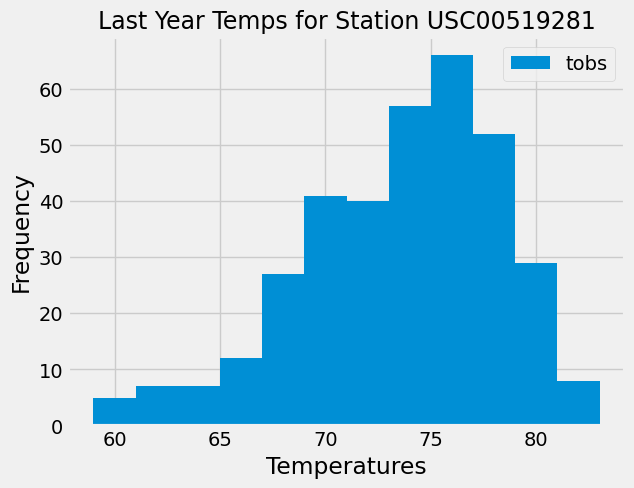

In [42]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
sel = [
    measurement.tobs
]

with Session() as session:
    data = session.query(*sel
        ).filter(measurement.station == most_active
        ).filter(measurement.date >= last_date
        ).all()

tobs_df = pd.DataFrame(data)
tobs_df.plot(
    kind = 'hist'
    ,bins = 12
    ,xlabel = 'Temperatures'
)
plt.title(
    f'Last Year Temps for Station {most_active}'
    ,loc = 'center'
    ,fontsize = 17
)
plt.show()

## Reset Engine & Binding

In [43]:
# Close Session
del Session

# Dispose Engine
engine.dispose()

print(
    'Session Maker deleted\n' +
    'Engine reset'
)

Session Maker deleted
Engine reset
